<a href="https://colab.research.google.com/github/BedinEduardo/Colab_Repositories/blob/master/PyTorch_Documenation_Training_With_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In past videos, we discussed and demostred:

* Buildong models with NN layers and functions of the torch.nn module
* The mechanics of autograd gradient computation, which is central to gradient-based model traning
* Using TensorBoard to visualize training progress and other activities

In this video, we will be adding some new tools to your inventory:

* We will get familiar with the dataset and dataloader abstractions, and how they ease the process of feeding data to your model during a training loop
* We will discuss specific loss functions and when to use them
* We will look at PyTorch optimizers, which implement algorithms, which implement algorithms to adjust model weights based on the outcome of a loss function

Finally, we will pull all of these togethere and see a full PyTorch training loop in action

## Dataset and DataLoader

The `Dataset` and `Dataloader` classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The `Dataset` is reponsible for accessing and processing single instances of data.

The `DataLoader` pulls instance of data from the `Dataset` - either automatically or with a sampler that you define - collects them in batches, and returns them for consuption by your training loop.
The `DataLoader` works with all kinds of datasets, regardless of the type of they contain.

We use `torchvision.transforms.Normalize()` to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# PyTorch TensorBoard Support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [ ]:
# Applying transforms Compose
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))]
)

In [ ]:
# Build datasets for training and validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data',
                                                  train=True,
                                                  transform=transform,
                                                  download=True)

validation_set = torchvision.datasets.FashionMNIST('./data',
                                                   train=False,
                                                   transform=transform,
                                                   download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]


In [ ]:
# Build the data loaders for our datasets; shuffle for training not for validation
training_dataloader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

In [ ]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [ ]:
#report the split sizes
print(f"Training set has {format(len(training_set))} instances")
print(f"Validation set has {format(len(validation_set))} instances")

Training set has 60000 instances
Validation set has 10000 instances


As always, let's visualize the data as a sanity check:

Shirt Shirt Sneaker Sneaker


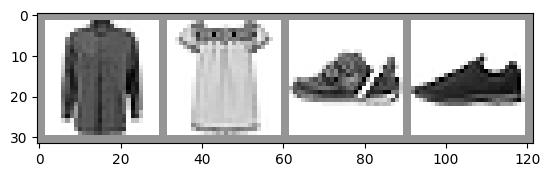

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg (1,2,0)))

dataiter = iter(training_dataloader)
images, labels = next(dataiter)

# Build a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print(' '.join(classes[labels[j]] for j in range(4)))

## The Model

The model we will use in this example is a variant of LeNet-5 - it should be familiar if you have watched the previous videos in this series.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
  def __init__(self):
    super(GarmentClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 *4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [ ]:
model = GarmentClassifier()

In [ ]:
print(model)

GarmentClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Loss Function

For this example, we will be using a cross-entropy loss.  For demostration purposes, we will build batches of dummy ouput and label values, run them thorugh the loss function, and examine the result.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
# Loss function expect data in batches, so we are building batches of 4
# Represents the model's confidence in each of the 10 classes, for a given input

dummy_outputs = torch.rand(4,10)
# Represents the correct class among the 10 being tested.
dummy_labels = torch.tensor([1,5,3,7])

print(dummy_outputs)
print("\n")
print(dummy_labels)

tensor([[0.0562, 0.7091, 0.2280, 0.6953, 0.0848, 0.8041, 0.6545, 0.0544, 0.8191,
         0.9474],
        [0.8819, 0.6581, 0.8237, 0.1040, 0.7286, 0.7849, 0.4379, 0.8986, 0.7640,
         0.5325],
        [0.0304, 0.8785, 0.2898, 0.0630, 0.1004, 0.2020, 0.9170, 0.3188, 0.6867,
         0.4683],
        [0.9012, 0.6297, 0.6335, 0.4831, 0.1909, 0.2243, 0.9390, 0.3029, 0.6049,
         0.6124]])


tensor([1, 5, 3, 7])


In [ ]:
loss = loss_fn(dummy_outputs, dummy_labels)

print(f"Total loss for this batch: {format(loss.item())}")

Total loss for this batch: 2.4061243534088135


## Optimizer

For this example, we will be using simpe **stochastic gradient descent** with momentum.

It can be instructive to try some variations on this optimizations scheme:

* Learning rate determines the size of the steps the optimizer takes. What does a different learning rate do to the your training results, in terms of accuracy and convergence time?
* Momentum nudges the optimizer in the direction of strongest gradient over multiple steps. What does changing this value do to your results?
* Try some different optimization algorithms, such as averaged SGS, Adagrad, or Adam. How do your results differ?

In [ ]:
# optimizer specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## The Training Loop

Below, we have a function that performs one training epoch. It enumerates data from DataLoader, and on each pass of the loop does the following:

* Gets a batch of training data from the DataLoader
* Zeros the optimizer gradients
* Performs an inference - that is, gets predictions from the model for an input batch
* Calculates the loss for that set of predictions vs. the labels on the datasset
* Calculates the backwards gradients over the learning weights
* Tells the optimzer to perform one learning step - that is, adjust the model's learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose.
* It reports on the loss for evey 1000 batches.
* Finally, it reports the average per-batch loss for the last 1000 batches, for comparision with a validation run

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0.
  last_loss = 0.

  # Here, we use enumerate - training_loader - instead of iter - training_loader - so that we can track the batch index and do some intra-epoch reporting
  for i, data in enumerate(training_dataloader):
    # Every data instance is an ouptut + label pair
    inputs, labels = data

    # Zero your gradients for every batch
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(inputs)

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather data and report
    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print(f' Batch {format(i+1)} | Loss: {last_loss}')
      tb_x = epoch_index * len(training_dataloader) + i +1
      tb_writer.add_scalar('Loss/train', last_loss, tb_x)
      running_loss = 0.

  return last_loss

## Per-Epoch Activity

There are a couple of things we will want to do once per epoch:

* Perform validation by checking our relative loss on a set of a data that was not used for training, and report this
* Save a copy of the model.

Here, we will do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [ ]:
# Initailizing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{format(timestamp)}')
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000

for epoch in range(EPOCHS):
  print(f"EPOCH: {format(epoch_number + 1)}")

  # Make sure gradient tracking is on, and do a pass over the data
  model.train(True)
  avg_loss = train_one_epoch(epoch_number, writer)

  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistcs for batch normalization
  model.eval()

  # Disable gradient computation and reduce memory comsuption
  with torch.no_grad():
    for i, vdata in enumerate(test_dataloader):
      vinputs, vlabels = vdata
      voutputs = model(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss

  avg_vloss = running_vloss / (i+1)
  print(f"LOSS train {format(avg_loss)} | valid: {format(avg_vloss)}")

  # Log the running loss averaged per batch for both training and validation
  writer.add_scalars('Training vs. Validation Loss',
                     { 'Training': avg_loss, 'Validation': avg_vloss},
                     epoch_number + 1)
  writer.flush()

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = f'model_{format(timestamp)}_{format(epoch_number)}'
    torch.save(model.state_dict(), model_path)

  epoch_number +=1

EPOCH: 1
 Batch 1000 | Loss: 1.622510337010026
 Batch 2000 | Loss: 0.83273185412772
 Batch 3000 | Loss: 0.7051361261811108
 Batch 4000 | Loss: 0.6159963581711054
 Batch 5000 | Loss: 0.6025558550967834
 Batch 6000 | Loss: 0.5785097821586532
 Batch 7000 | Loss: 0.5452367549687624
 Batch 8000 | Loss: 0.5117050479456083
 Batch 9000 | Loss: 0.48152009956369873
 Batch 10000 | Loss: 0.47623462688550355
 Batch 11000 | Loss: 0.44297481009166223
 Batch 12000 | Loss: 0.44969412846304474
 Batch 13000 | Loss: 0.4411469753604615
 Batch 14000 | Loss: 0.4203222837037756
 Batch 15000 | Loss: 0.4364258945485344
LOSS train 0.4364258945485344 | valid: 0.40859439969062805
EPOCH: 2
 Batch 1000 | Loss: 0.38740461650589714
 Batch 2000 | Loss: 0.38929962539949337
 Batch 3000 | Loss: 0.39275878414453474
 Batch 4000 | Loss: 0.37453301887694396
 Batch 5000 | Loss: 0.37172354366839866
 Batch 6000 | Loss: 0.3780099771274545
 Batch 7000 | Loss: 0.3942687249031005
 Batch 8000 | Loss: 0.37533525120004196
 Batch 9000 |

As always, let's visualize the data as a sanity check:

Trouser Coat Sandal Sandal


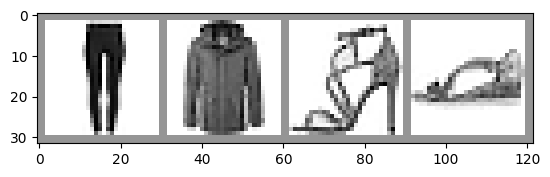

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)  # less the color channel
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.tranpose(npimg, (1,2,0)))

dataiter = iter(training_dataloader)
images, labels = next(dataiter)

# Build a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

print(' '.join(classes[labels[j]] for j in range(4)))

Toload a saved version of the model:

In [ ]:
saved_model = GarmentClassifier()
saved_model.state_dict(torch.load(model_path))

<ipython-input-18-36f90c080f5f>:2: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  saved_model.state_dict(torch.load(model_path))


OrderedDict([('conv1.weight',
              tensor([[[[ 0.0127,  0.0763, -0.1238, -0.0374, -0.0447],
                        [-0.0881,  0.1750,  0.1158,  0.1528, -0.1404],
                        [ 0.1777, -0.1486, -0.1900,  0.0094, -0.0403],
                        [-0.0427,  0.0150, -0.0553,  0.0527, -0.0295],
                        [ 0.1168,  0.0217,  0.0441,  0.1796, -0.1982]]],
              
              
                      [[[ 0.1816,  0.1895,  0.1782,  0.1311,  0.0604],
                        [ 0.0948,  0.1949, -0.1013, -0.1404, -0.1491],
                        [-0.0835,  0.1856, -0.1179,  0.1970,  0.1638],
                        [-0.0363, -0.0230, -0.1870, -0.1822,  0.1267],
                        [ 0.1142,  0.0481, -0.0018,  0.0493,  0.0620]]],
              
              
                      [[[ 0.0185, -0.1802, -0.1275,  0.0772,  0.0513],
                        [ 0.1041,  0.1925,  0.0580, -0.1581,  0.1476],
                        [ 0.1258, -0.0786,  0.0178, -0